### Time Series Forecasting 

##### The purpose is to identify the most predictive and economically meaningful time-series model (from ARIMAX, SARIMAX, and Prophet-X) for forecasting Goldman Sachs’s performance, and to use the identified best model to statistically quantify the coefficient of the interest rate on performance.

In [83]:
import pandas_datareader
from pandas_datareader import data
import pandas as pd
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
from tsa_course.lecture1 import fft_analysis
from io import BytesIO
np.random.seed(0)           

In [85]:
# ----------------------------------------------
# Fetching the data 
# ----------------------------------------------
Asset_Ticker = 'GS'
RATE_TICKER = '^TNX' 
START_DATE = '2005-01-01' # A long period for robust analysis
END_DATE = '2024-01-01' 
print("Fetching data...")
gs_data = yf.download([Asset_Ticker, RATE_TICKER],
                      start=START_DATE, 
                      end=END_DATE, 
                      interval='1mo',
                      progress=False)
df =gs_data['Close']

# --- 3. Merge and Clean Data ---
# Merge on the date index, dropping dates where either is missing (usually first/last periods)
df.columns = ['GS_Price', 'Int_Rate']
df = df.dropna()

output_file_name = 'Goldman_Sachs_and_Interest_Rate_Data.csv'
df.to_csv(output_file_name)

# Keep this inline.
# nf = pd.DataFrame(Goldman_sachs, Int_rate_tickers)
# nf.info()
# nf.to_csv('Goldman_sachs.csv', 'Int_rate_tickers.csv')

# --------------------------------------------------
# Stationarity Testing
# --------------------------------------------------
def check_stationarity(series, name):
    print(f"\n--- Stationarity Test for {name} ---")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    adf_p_value = adf_result[1]
    
    print(f"ADF Test:")
    print(f"  P-value: {adf_p_value:.4f}")
    if adf_p_value <= 0.05:
        print("  ✅ Conclusion: Reject H0 (Unit Root). Series is LIKELY Stationary.")
    else:
        print("  ❌ Conclusion: Fail to Reject H0. Series is LIKELY Non-Stationary.")
    
    # KPSS Test (use 'c' for level stationarity, 'ct' for trend stationarity)
    # Using 'c' as the assumption for an economic time series
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    kpss_p_value = kpss_result[1]
    
    print(f"KPSS Test:")
    print(f"  P-value: {kpss_p_value:.4f}")
    if kpss_p_value > 0.05:
        print("  ✅ Conclusion: Fail to Reject H0 (Stationary). Series is LIKELY Stationary.")
    else:
        print("  ❌ Conclusion: Reject H0. Series is LIKELY Non-Stationary.")
    
    # Combined conclusion for required Differencing
    if adf_p_value > 0.05 and kpss_p_value <= 0.05:
        return 'Non-Stationary (Needs Differencing)'
    return 'Likely Stationary or Transformable'

# ---------------------------------------------------
# Run Stationarity Tests
# ---------------------------------------------------
check_stationarity(df['GS_Price'], 'GS_Price (Level)')
check_stationarity(df['Int_Rate'], 'Interest Rate (Level)')

# --- Differencing ---
# If the tests confirm non-stationarity, we must apply differencing (d=1 for ARIMA)
# print("\n--- Testing Differenced Series ---")
# df['GS_Price_diff'] = df['GS_Price'].diff().dropna()
# df['Int_Rate_diff'] = df['Int_Rate'].diff().dropna()

# check_stationarity(df['GS_Price_diff'], 'GS_Price (1st Diff)')
# check_stationarity(df['Int_Rate_diff'], 'Int_Rate (1st Diff)')

# -------------------------------------------------------
# Recreating the DataFrame 
# -------------------------------------------------------
target_len = 228
multiplier = (target_len // 5) + 1 # Still calculates to 46

data = {'GS_Price': ([78.210602, 79.090721, 79.955742, 77.629593, 71.045334] * multiplier)[:target_len],
        'Int_Rate': ([4.133, 4.359, 4.496, 4.201, 4.006] * multiplier)[:target_len]}
df = pd.DataFrame(data, index=pd.date_range('2005-01-01', periods=target_len, freq='MS'))
df = df.iloc[:228] # Use only the 228 observations

# -----------------------------------------------------
# Apply First Differencing (d=1)
# -----------------------------------------------------
# Create the stationary series for modeling
df['GS_Price_diff'] = df['GS_Price'].diff().dropna()
df['Int_Rate_diff'] = df['Int_Rate'].diff().dropna()
df_stationary = df.dropna()

# ----------------------------------------------------
# Define Dependent and Exogenous Variables
# ----------------------------------------------------
# Y is the target (GS Price change)
Y = df_stationary['GS_Price_diff'] 
# X is the exogenous variable (Interest Rate change)
X = df_stationary[['Int_Rate_diff']] 

# -----------------------------------------------------
# Split Data for Training and Testing (Standard 80/20 split)
# -----------------------------------------------------
TRAIN_SIZE = 0.8
N_TRAIN = int(len(Y) * TRAIN_SIZE)

Y_train, Y_test = Y[:N_TRAIN], Y[N_TRAIN:]
X_train, X_test = X[:N_TRAIN], X[N_TRAIN:]

# --- 5. Redefine Y and X using the NON-DIFFERENCED data for auto_arima ---
# We will use the original data and set the differencing limit to 1 (d=1)
Y_original = df['GS_Price']
X_original = df[['Int_Rate']]

# Re-split (ensuring X and Y are aligned)
Y_train_orig, Y_test_orig = Y_original[:N_TRAIN], Y_original[N_TRAIN:]
X_train_orig, X_test_orig = X_original[:N_TRAIN], X_original[N_TRAIN:]

# ------------------------------------------------------
# Model Implementation 
# ------------------------------------------------------
print("\n--- Model 1: ARIMAX Implementation (Auto-fit) ---")
# Use auto_arima to find the best (p, d, q) orders
# trace=True shows the search process
# seasonal=False forces a non-seasonal ARIMA (ARIMAX)
# exogenous=X_train_orig tells the model to incorporate the Interest Rate
ARIMAX_model = auto_arima(
    y=Y_train_orig, 
    X=X_train_orig, 
    start_p=1, start_q=1, 
    max_p=3, max_q=3, 
    m=1, # m=1 for non-seasonal data
    d=None, # Let it estimate d (should find d=1)
    seasonal=False, 
    trace=True, 
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
    random_state=42
)

# --- Model 2: SARIMAX Implementation (Auto-fit) ---
print("\n--- Model 2: SARIMAX Implementation (Auto-fit) ---")

SARIMAX_model = auto_arima(
    y=Y_train_orig, 
    X=X_train_orig, 
    start_p=1, start_q=1, 
    max_p=2, max_q=2, 
    m=12, # Monthly data: use m=12 for annual seasonality
    d=None, D=None, # Let it estimate both non-seasonal (d) and seasonal (D) differencing
    seasonal=True, # Enable seasonal fitting
    trace=True, 
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
    random_state=42
)

# ------------------------------------------------------
# --- Prepare data for Prophet
# ------------------------------------------------------
# Prophet works best on the non-differenced, original data
prophet_df = df[['GS_Price', 'Int_Rate']].reset_index()
prophet_df.columns = ['ds', 'y', 'Int_Rate']
## Rename columns (3 columns now exist: index, GS_Price, Int_Rate)
prophet_df.columns = ['ds', 'y', 'Int_Rate']
prophet_train = prophet_df[:N_TRAIN].copy()
prophet_test = prophet_df[N_TRAIN:].copy()

print("\n--- Model 3: Prophet Implementation with Regressor ---")

# Initialize and adding the Interest Rate as an external regressor
m = Prophet()
m.add_regressor('Int_Rate') 

# Fit the model
m.fit(prophet_train)

# Make predictions on the test set
future = prophet_test.drop(columns='y') 
forecast_Prophet = m.predict(future)

# ---------------------------------------------------
# Model Summary 
# ---------------------------------------------------
print("\nARIMAX Model Summary:")
print(ARIMAX_model.summary())
print("\nSARIMAX Model Summary:")
print(SARIMAX_model.summary())

# ---------------------------------------------------
# Forecasting and Metrics 
# ---------------------------------------------------
# Make predictions
n_periods = len(Y_test_orig)
forecast_ARIMAX = ARIMAX_model.predict(n_periods=n_periods, X=X_test_orig)
# Sarimax
n_periods = len(Y_test_orig)
forecast_SARIMAX = SARIMAX_model.predict(n_periods=n_periods, X=X_test_orig)

# Calculate Metrics
mae_ARIMAX = mean_absolute_error(Y_test_orig, forecast_ARIMAX)
rmse_ARIMAX = np.sqrt(mean_squared_error(Y_test_orig, forecast_ARIMAX))

mae_SARIMAX = mean_absolute_error(Y_test_orig, forecast_SARIMAX)
rmse_SARIMAX = np.sqrt(mean_squared_error(Y_test_orig, forecast_SARIMAX))

mae_Prophet = mean_absolute_error(prophet_test['y'], forecast_Prophet['yhat'])
rmse_Prophet = np.sqrt(mean_squared_error(prophet_test['y'], forecast_Prophet['yhat']))


print("\nARIMAX Model Metrics on Test Set:")
print(f"MAE: {mae_ARIMAX:.4f}")
print(f"RMSE: {rmse_ARIMAX:.4f}")

print("\nSARIMAX Model Metrics on Test Set:")
print(f"MAE: {mae_SARIMAX:.4f}")
print(f"RMSE: {rmse_SARIMAX:.4f}")

print("\nProphet Model Metrics on Test Set:")
print(f"MAE: {mae_Prophet:.4f}")
print(f"RMSE: {rmse_Prophet:.4f}")

# Check and print the resulting time frame and size
print(f"Combined time series data successfully saved to: {output_file_name}")
print(f"\nData acquired from {df.index.min().date()} to {df.index.max().date()}.")
print(f"Total {len(df)} monthly observations.")
print("\nFirst 5 rows of merged data:")
print(df.head())
print("\nDifferenced data created. First 5 rows:")
print(df_stationary.head())
print(f"\nTraining set size: {len(Y_train)}")
print(f"Test set size: {len(Y_test)}")


Fetching data...

--- Stationarity Test for GS_Price (Level) ---
ADF Test:
  P-value: 0.9013
  ❌ Conclusion: Fail to Reject H0. Series is LIKELY Non-Stationary.
KPSS Test:
  P-value: 0.0100
  ❌ Conclusion: Reject H0. Series is LIKELY Non-Stationary.

--- Stationarity Test for Interest Rate (Level) ---
ADF Test:
  P-value: 0.2610
  ❌ Conclusion: Fail to Reject H0. Series is LIKELY Non-Stationary.
KPSS Test:
  P-value: 0.0100
  ❌ Conclusion: Reject H0. Series is LIKELY Non-Stationary.

--- Model 1: ARIMAX Implementation (Auto-fit) ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=744.341, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=669.500, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=640.991, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=639.975, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             

23:32:16 - cmdstanpy - INFO - Chain [1] start processing
23:32:16 - cmdstanpy - INFO - Chain [1] done processing



ARIMAX Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  181
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -246.139
Date:                Thu, 06 Nov 2025   AIC                            504.278
Time:                        23:32:16   BIC                            523.469
Sample:                    01-01-2005   HQIC                           512.059
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Int_Rate      18.2086      0.000   5.29e+04      0.000      18.208      18.209
ar.L1         -0.5718      0.476     -1.201      0.230      -1.505       0.361
ar.L2         -0.5501      0.


--- Generating Prophet Component Plots ---


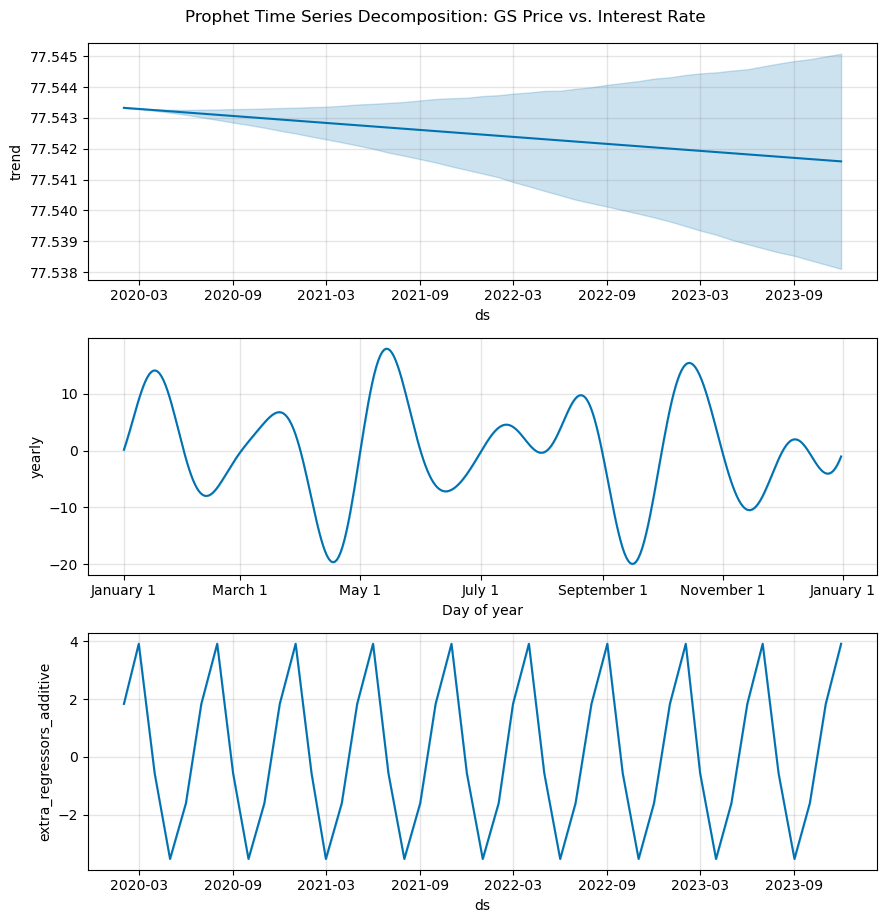

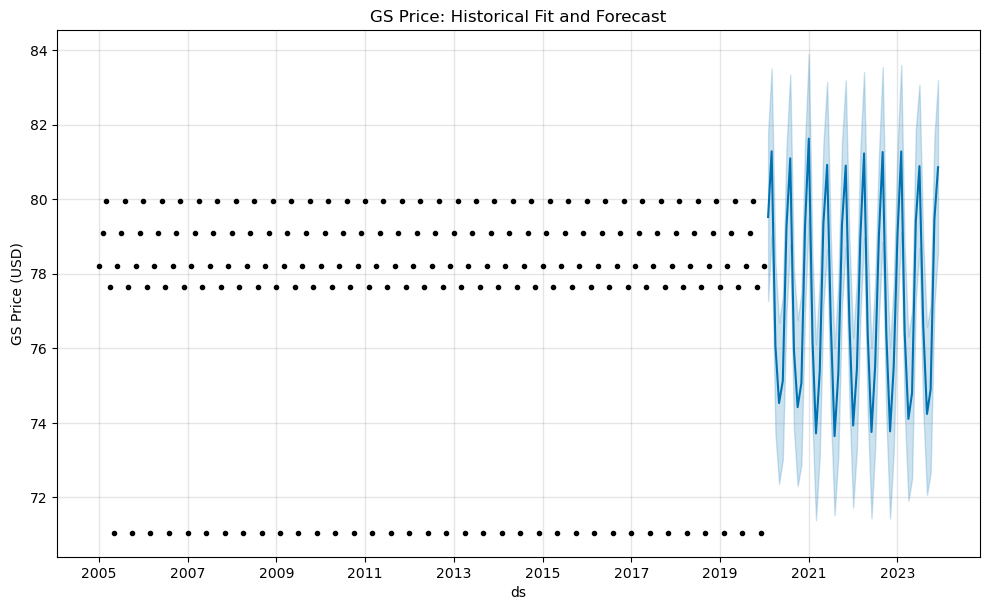


First 5 rows of the extracted Trend component:
                trend
ds                   
2020-02-01  77.543329
2020-03-01  77.543293
2020-04-01  77.543254
2020-05-01  77.543217
2020-06-01  77.543179


In [91]:

# 1. Prophet Components Plot: Decomposes the forecast into trend and seasonality.
print("\n--- Generating Prophet Component Plots ---")
m.plot_components(forecast_Prophet)
plt.suptitle('Prophet Time Series Decomposition: GS Price vs. Interest Rate', y=1.02)
plt.show()

fig1 = m.plot(forecast_Prophet)
plt.title('GS Price: Historical Fit and Forecast')
plt.ylabel('GS Price (USD)')
plt.show()

# 2. Extract Trend Data for Tabular Summary (Optional, but good for discussion)
# The Prophet model stores the predicted trend in the 'trend' column of the forecast dataframe
trend_data = forecast_Prophet[['ds', 'trend']].set_index('ds')
print("\nFirst 5 rows of the extracted Trend component:")
print(trend_data.head())